In [1]:
import os
import sys

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import shapely
from shapely.geometry import (
    LineString,
    MultiLineString,
    MultiPoint,
    MultiPolygon,
    Point,
    Polygon,
)

import flopy
import flopy.discretization as fgrid
import flopy.plot as fplot
from flopy.utils import GridIntersect
#from pulp import *

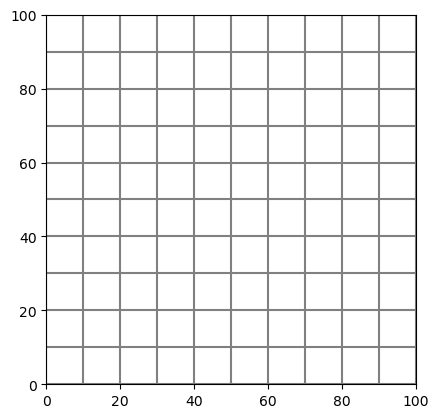

In [2]:
delc = 10 * np.ones(10, dtype=float)
delr = 10 * np.ones(10, dtype=float)
xoff = 0.0
yoff = 0.0
angrot = 0.0
sgr = fgrid.StructuredGrid(
    delc, delr, top=None, botm=None, xoff=xoff, yoff=yoff, angrot=angrot
)
sgr.plot()

In [3]:
p = Polygon(
    shell=[
        (15, 15),
        (20, 50),
        (35, 80.0),
        (80, 50),
        (80, 40),
        (40, 5),
        (15, 12),
    ],
    holes=[[(25, 25), (25, 45), (45, 45), (45, 25)]],
)
ix = GridIntersect(sgr, method="vertex")


In [4]:
ls1 = LineString([(95, 105), (30, 50)])
ls2 = LineString([(30, 50), (90, 22)])
ls3 = LineString([(90, 22), (0, 0)])
mls = MultiLineString(lines=[ls1, ls2, ls3])
result = ix.intersect(mls)

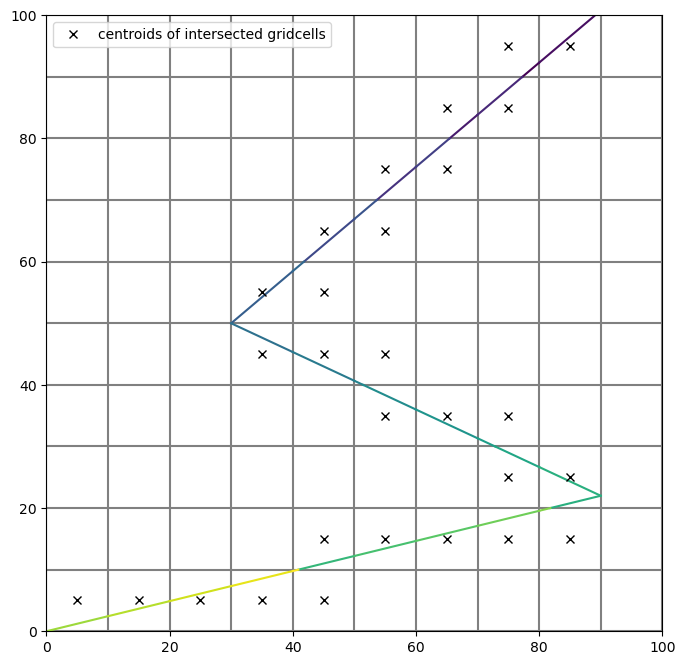

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sgr.plot(ax=ax)
ix.plot_linestring(result, ax=ax, cmap="viridis")

for irow, icol in result.cellids:
    (h2,) = ax.plot(
        sgr.xcellcenters[0, icol],
        sgr.ycellcenters[irow, 0],
        "kx",
        label="centroids of intersected gridcells",
    )

ax.legend([h2], [i.get_label() for i in [h2]], loc="best")

In [6]:
print(result)

[((0, 7), <LINESTRING (80 92.308, 77.273 90)>,  3.57259854)
 ((0, 8), <LINESTRING (89.091 100, 80 92.308)>, 11.90866179)
 ((1, 6), <LINESTRING (70 83.846, 65.455 80)>,  5.9543309 )
 ((1, 7), <LINESTRING (77.273 90, 70 83.846)>,  9.52692944)
 ((2, 5), <LINESTRING (60 75.385, 53.636 70)>,  8.33606326)
 ((2, 6), <LINESTRING (65.455 80, 60 75.385)>,  7.14519708)
 ((3, 4), <LINESTRING (50 66.923, 41.818 60)>, 10.71779561)
 ((3, 5), <LINESTRING (53.636 70, 50 66.923)>,  4.76346472)
 ((4, 3), <LINESTRING (40 58.462, 30 50)>, 13.09952797)
 ((4, 4), <LINESTRING (41.818 60, 40 58.462)>,  2.38173236)
 ((5, 3), <LINESTRING (30 50, 40 45.333)>, 11.0352969 )
 ((5, 4), <LINESTRING (40 45.333, 50 40.667)>, 11.0352969 )
 ((5, 5), <LINESTRING (50 40.667, 51.429 40)>,  1.57647099)
 ((6, 5), <LINESTRING (51.429 40, 60 36)>,  9.45882592)
 ((6, 6), <LINESTRING (60 36, 70 31.333)>, 11.0352969 )
 ((6, 7), <LINESTRING (70 31.333, 72.857 30)>,  3.15294197)
 ((7, 7), <LINESTRING (72.857 30, 80 26.667)>,  7.88235

In [7]:
class cell():
    def __init__ (self, cell_id, line_point_0, line_point_1, grid):
        self.top_right_vert = None
        self.bot_right_vert = None
        self.bot_left_vert = None
        self.top_left_vert = None
        self.edges = {}
        self.distance_coefs = {}
        self.cell_id = cell_id
        self.cell_row = cell_id[0]
        self.cell_column = cell_id[1]
        
        # use the grid to get the vertices for this cell
        self.get_verts(grid)
        # now make some edges with them. 
        # edges will be stored as a dict in the form {cell_id_top: (top_left_vert, top_right_vert)..... }
        self.get_edges()
        # now get the distance coeficents. Will be stored in the same structure as the edges
        self.get_distance_coefs(line_point_0, line_point_1)
        
    def get_verts(self, grid):
        # find the verts with the grid function
        vert_list = grid.get_cell_vertices(self.cell_row, self.cell_column)
        assert len(vert_list) == 4, '%s vertices were found on cell %s. There should be 4' % (len(vert_list), self.cell_id)
        # figure out which vertex is which
        x_cords = [vert[0] for vert in vert_list]
        y_cords = [vert[1] for vert in vert_list]
        for vert in vert_list:
            if vert[0] == max(x_cords) and vert[1] == max(y_cords):
                self.top_right_vert = vert
            elif vert[0] == max(x_cords) and vert[1] == min(y_cords):
                self.bot_right_vert = vert
            elif vert[0] == min(x_cords) and vert[1] == min(y_cords):
                self.bot_left_vert = vert
            elif vert[0] == min(x_cords) and vert[1] ==  max(y_cords):
                self.top_left_vert = vert
            else:
                raise ValueError('A vertex could not be classified as the corner of a square. \n Are the cells squares?')
    def get_edges(self):
        # group the vertices into edges and lable what side there on. 
        cell_id_string = str(self.cell_row) + '_' + str(self.cell_column) + '_'
        self.edges[cell_id_string + 'top'] = [self.top_left_vert, self.top_right_vert]
        self.edges[cell_id_string + 'right'] = [self.top_right_vert, self.bot_right_vert]
        self.edges[cell_id_string + 'bot'] = [self.bot_right_vert, self.bot_left_vert]
        self.edges[cell_id_string + 'left'] = [self.bot_left_vert, self.top_left_vert]
        
    def get_distance_coefs(self, line_point_0, line_point_1):
        # get the x and y cords of the ,iddle of the line that crosses the cell
        x_center = (line_point_0[0] + line_point_1[0]) / 2
        y_center = (line_point_0[1] + line_point_1[1]) / 2
        print(x_center, y_center)
        self.distance_coefs['top'] = self.top_right_vert[1] - y_center
        self.distance_coefs['right'] = self.top_right_vert[0] - x_center
        self.distance_coefs['bot'] =  y_center - self.bot_left_vert[1]
        self.distance_coefs['left'] =  x_center - self.bot_left_vert[0]

In [11]:
for val in result:
    if isinstance(val[1], shapely.geometry.linestring.LineString):
        print(val[1].xy[0])
    elif isinstance(val[1], shapely.geometry.multilinestring.MultiLineString):
        test = val
        print(dir(val[1]))

array('d', [80.0, 77.27272727272727])
array('d', [89.0909090909091, 80.0])
array('d', [70.0, 65.45454545454545])
array('d', [77.27272727272727, 70.0])
array('d', [60.0, 53.63636363636363])
array('d', [65.45454545454545, 60.0])
array('d', [50.0, 41.81818181818182])
array('d', [53.63636363636363, 50.0])
array('d', [40.0, 30.0])
array('d', [41.81818181818182, 40.0])
array('d', [30.0, 40.0])
array('d', [40.0, 50.0])
array('d', [50.0, 51.42857142857143])
array('d', [51.42857142857143, 60.0])
array('d', [60.0, 70.0])
array('d', [70.0, 72.85714285714286])
array('d', [72.85714285714286, 80.0])
['__and__', '__bool__', '__class__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__geo_interface__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__nonzero__', '__or__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__slots__', '__str

In [17]:
for line in test[1]:
    print('here', 
          line)

TypeError: 'MultiLineString' object is not iterable

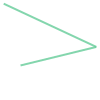

In [18]:
test[1]

In [25]:
from shapely.geometry import MultiLineString
coords = [((0, 0), (1, 1)), ((-1, 0), (1, 0))]
lines = MultiLineString(coords)
lines.geoms